In [54]:
from files.utils.utility_functions import *
from files.utils.constants import *

from files.pif.pif import *

In [55]:
def load_dataset_by_name(name, with_outliers=True):
    file_path = joinpath("..", "..", "datasets", "2d",
                        "circles" if "circle" in name.lower() else "lines",
                        "with_outliers" if with_outliers else "no_outliers")
    if with_outliers:
        ds = read_np_array(joinpath(file_path, f"{name}.csv"))
        real_gt = read_np_array(joinpath(file_path, f"{name}_gt.csv"))
    else:
        with open(joinpath(file_path, f"{name}.csv"), 'r') as f:
            content = f.read().split("\n")
            if "" in content:
                content.remove("")
            X = np.array(content[0].split(","), dtype=float)
            y = np.array(content[1].split(","), dtype=float)
            ds = np.dstack((X, y))[0]
        with open(joinpath(file_path, f"{name}_gt.csv"), 'r') as f:
            real_gt = np.array([int(float(l))
                               for l in f.read().split("\n") if l != ''])
    ds = ds.astype(float)
    gt = real_gt.astype(int).reshape(len(ds))
    gt[gt > 1] = 1
    return ds, gt

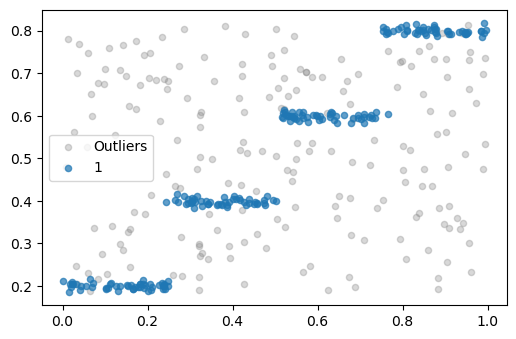

In [56]:
ds, gt = load_dataset_by_name("stair4", with_outliers=True)
fig = plt.figure(dpi=100)
ax = fig.add_subplot()
ax.set_aspect("equal")
plot_clusters(gt, ds, ax=ax)

Anomaly Detection
--------------------------------------------------
Building RanSac models
Iteration 400/400: [==============================] (100%) ETA: 0:00:00.5424961
--------------------------------------------------
Building preference matrix
--------------------------------------------------
Building Voronoi Forest
--------------------------------------------------
Done


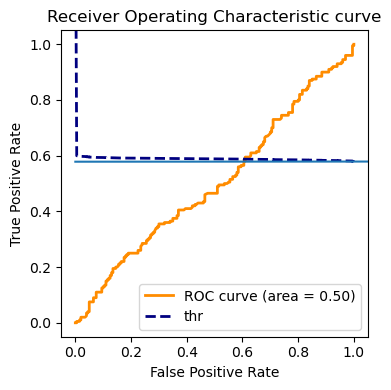

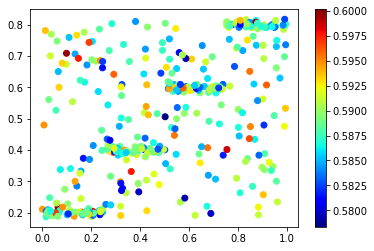

In [57]:
pif = PreferenceIsolationForest(data=ds, model_name=SOM, in_th=0.004*3, sampling=LOCALIZED)
# models_ithrs = np.array(pif.build_models(num_models=1*len(ds)))
scores = pif.anomaly_detection(num_models=1*len(ds), mss=10)
make_roc(gt, scores);
plt.scatter(ds[:,0], ds[:,1], c=scores, cmap="jet")
plt.colorbar()

In [58]:
x0_min, x0_max = ds[:, 0].min() - .1, ds[:, 0].max() + .1
x1_min, x1_max = ds[:, 1].min() - .1, ds[:, 1].max() + .1

h = .01
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h), np.arange(x1_min, x1_max, h))
data = np.c_[xx0.ravel(), xx1.ravel()]
data.shape

(10080, 2)

In [59]:
preference_matrix, _ = build_preference_matrix(
                data=data, models_ithrs=pif.models_ithrs, verbose=1)
pif.voronoi.fit(preference_matrix)
scores = pif.voronoi.score_samples(preference_matrix)

--------------------------------------------------
Building preference matrix


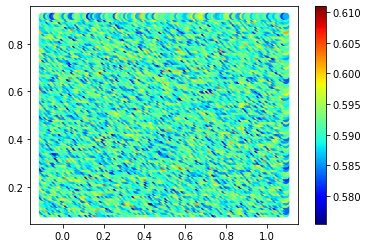

In [60]:
plt.scatter(data[:,0], data[:,1], c=scores, cmap="jet")
plt.colorbar()

In [61]:
from multiprocessing.pool import Pool
from multiprocessing import Manager
import numpy as np
import itertools, time, os


def func(inp, opts):
    # time.sleep(np.random.uniform()*1)
    idx, num = inp
    opts[idx] += [num]
    return opts

with Manager() as manager:
    opts = manager.dict()
    inp = np.dstack((np.random.randint(4, size=(100)), np.random.uniform(size=(100))))[0]
    opts[0] = []
    opts[1] = []
    opts[2] = []
    opts[3] = []
    
    os.makedirs("prova", exist_ok=True)

    print(inp.shape)
    processes = [multiprocessing.Process(
            target=func, args=[i, opts]) for i in inp]
    for p in processes:
        p.start()
    for p in processes:
        p.join()

    print({k: len(v) for k, v in dict(opts).items()})
    print(np.sum([len(v) for v in dict(opts).values()]))
    # print(dict(opts))

(100, 2)
{0: 23, 1: 24, 2: 26, 3: 27}
100


In [62]:
import multiprocessing

manager = multiprocessing.Manager()
shared_dict = manager.dict()

def worker1(d):
    d["a"] = 1

def worker2(d):
    d["b"] = 2

process1 = multiprocessing.Process(
    target=worker1, args=[shared_dict])
process2 = multiprocessing.Process(
    target=worker2, args=[shared_dict])

process1.start()
process2.start()
process1.join()
process2.join()

print(shared_dict)

{'b': 2, 'a': 1}
